In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer,StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest,f_classif
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import Ridge,Lasso,LinearRegression,SGDRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.feature_selection import VarianceThreshold,RFE
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

2024-04-29 20:44:36.413478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 20:44:36.413570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 20:44:36.549484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Datasets

In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


In [4]:
test=pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
sample_submission=pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

Description:-

* Length: Longest shell measurement
* Diameter: Perpendicular to length
* Height: With meat in shell
* Whole weight: Whole Abalone
* Whole Weight.1: Weight of Meat (Shucked Weight)
* Whole Weight.2: Gut weight after bleeding (Viscera Weight)
* Shell Weight: After being dried
* Rings: +1.5 gives age in years

# Assessing the Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [6]:
train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
train.duplicated().sum()

0

We have no null or duplicated values. There might be some outliers in some columns as we can see from the describe function, will check that later

Except Sex, we do not have any other categorical columns. Also, id seems useless so dropping it

In [8]:
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)

As we have rings as Target column, we have a Regression Problem at hand. Let's start by Exploratory Data Analysis and find out insights about the data

# Exploratory Data Analysis

<Axes: xlabel='Sex', ylabel='count'>

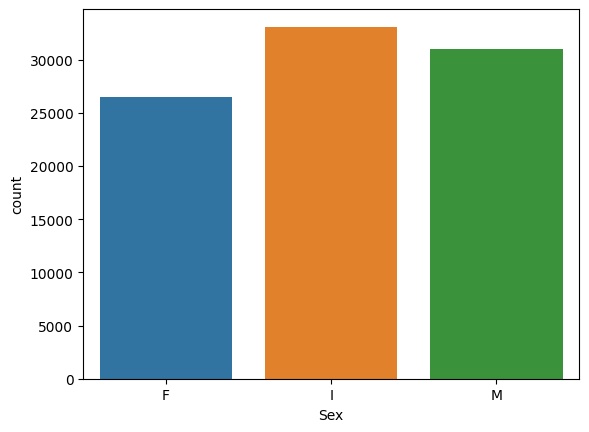

In [9]:
sns.countplot(train,x='Sex')

'I' basically represents infant and it has the highest majority in the dataset forllowed by Males and then Females

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Length', ylabel='Density'>

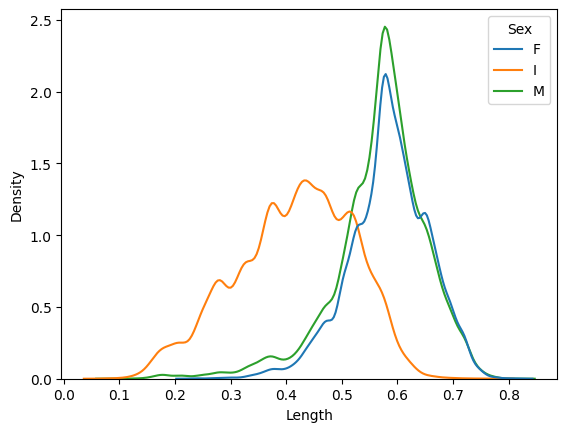

In [10]:
sns.kdeplot(x=train['Length'],hue=train['Sex'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Diameter', ylabel='Density'>

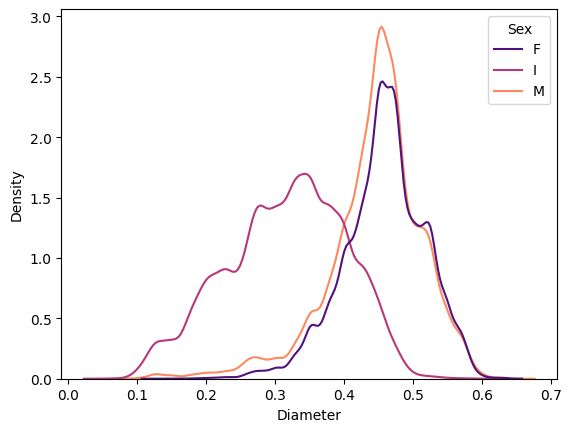

In [11]:
sns.kdeplot(x=train['Diameter'],hue=train['Sex'],palette='magma')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Height', ylabel='Density'>

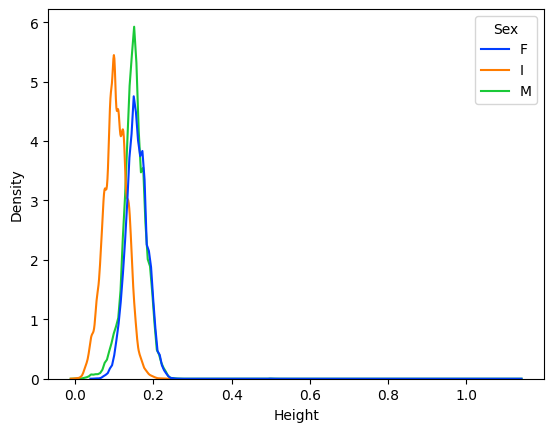

In [12]:
sns.kdeplot(x=train['Height'],hue=train['Sex'],palette='bright')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Whole weight', ylabel='Density'>

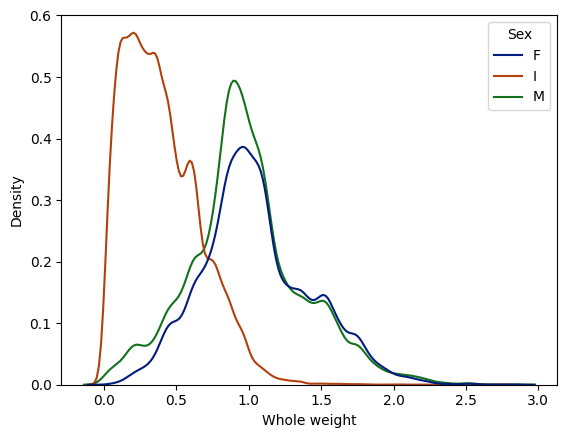

In [13]:
sns.kdeplot(x=train['Whole weight'],hue=train['Sex'],palette='dark')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Whole weight.1', ylabel='Density'>

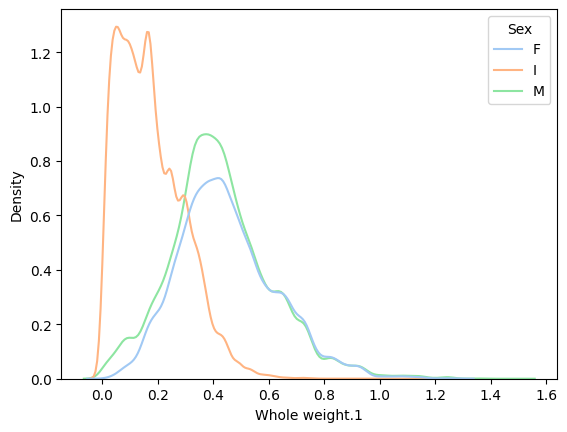

In [14]:
sns.kdeplot(x=train['Whole weight.1'],hue=train['Sex'],palette='pastel')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Whole weight.2', ylabel='Density'>

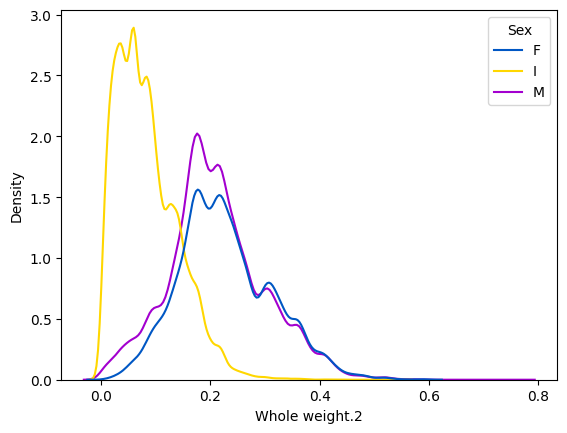

In [16]:
sns.kdeplot(x=train['Whole weight.2'],hue=train['Sex'],palette='prism')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Shell weight', ylabel='Density'>

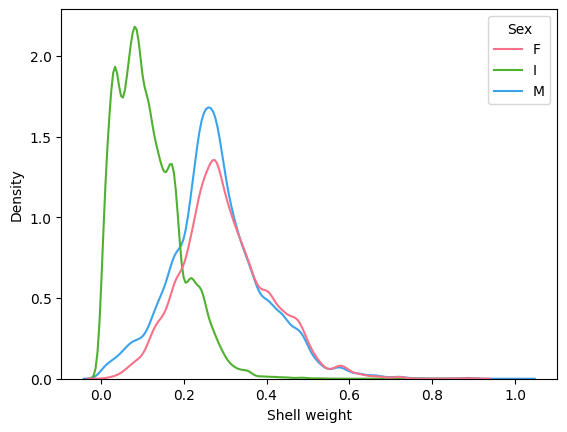

In [17]:
sns.kdeplot(x=train['Shell weight'],hue=train['Sex'],palette='husl')

We have removed a few outliers by visualising the kde plots in the data

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Length', ylabel='Height'>

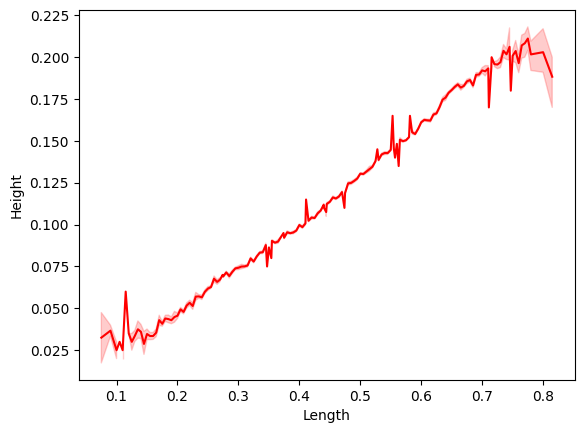

In [18]:
sns.lineplot(train,x='Length',y='Height',color='red')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Whole weight', ylabel='Height'>

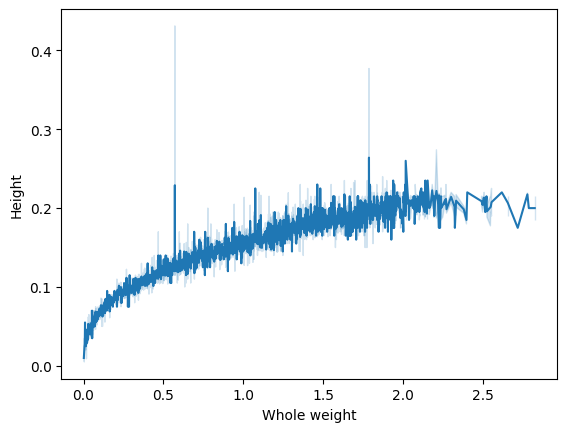

In [19]:
sns.lineplot(train,x='Whole weight',y='Height')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Whole weight.2', ylabel='Whole weight.1'>

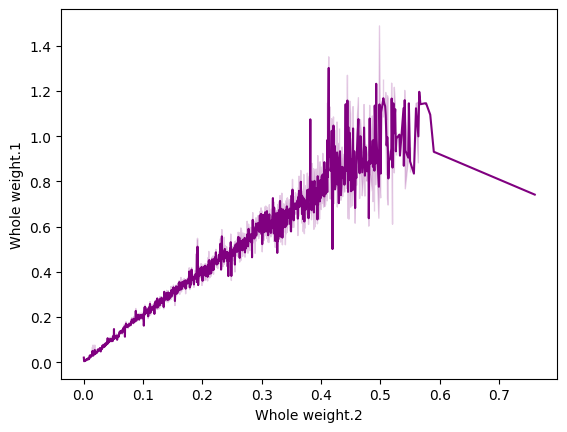

In [20]:
sns.lineplot(train,x='Whole weight.2',y='Whole weight.1',color='purple')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Whole weight', ylabel='Shell weight'>

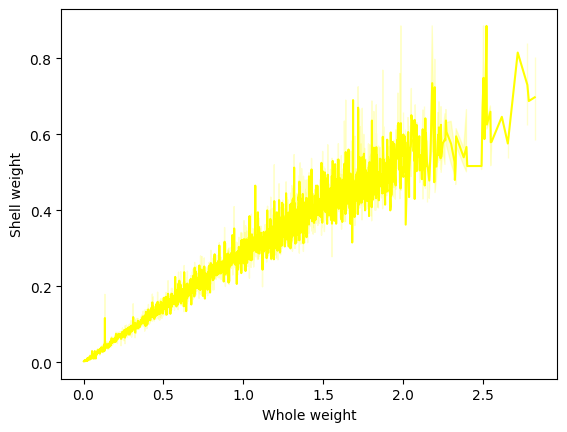

In [21]:
sns.lineplot(train,x='Whole weight',y='Shell weight',color='yellow')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Diameter', ylabel='Whole weight'>

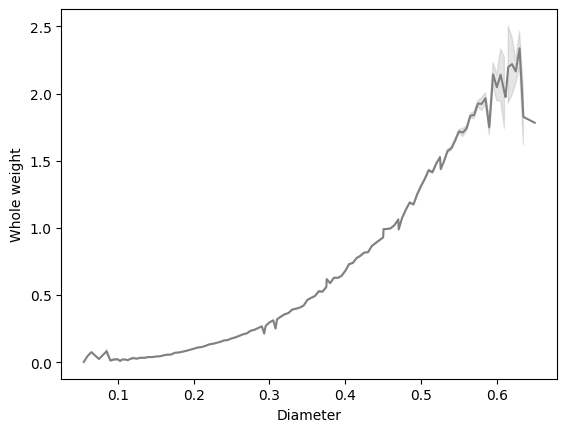

In [22]:
sns.lineplot(train,x='Diameter',y='Whole weight',color='gray')

Most of the columns have a strong linear relation with each other

In [23]:
num_cols=['Whole weight','Length','Diameter','Whole weight.1','Whole weight.2','Shell weight','Height']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

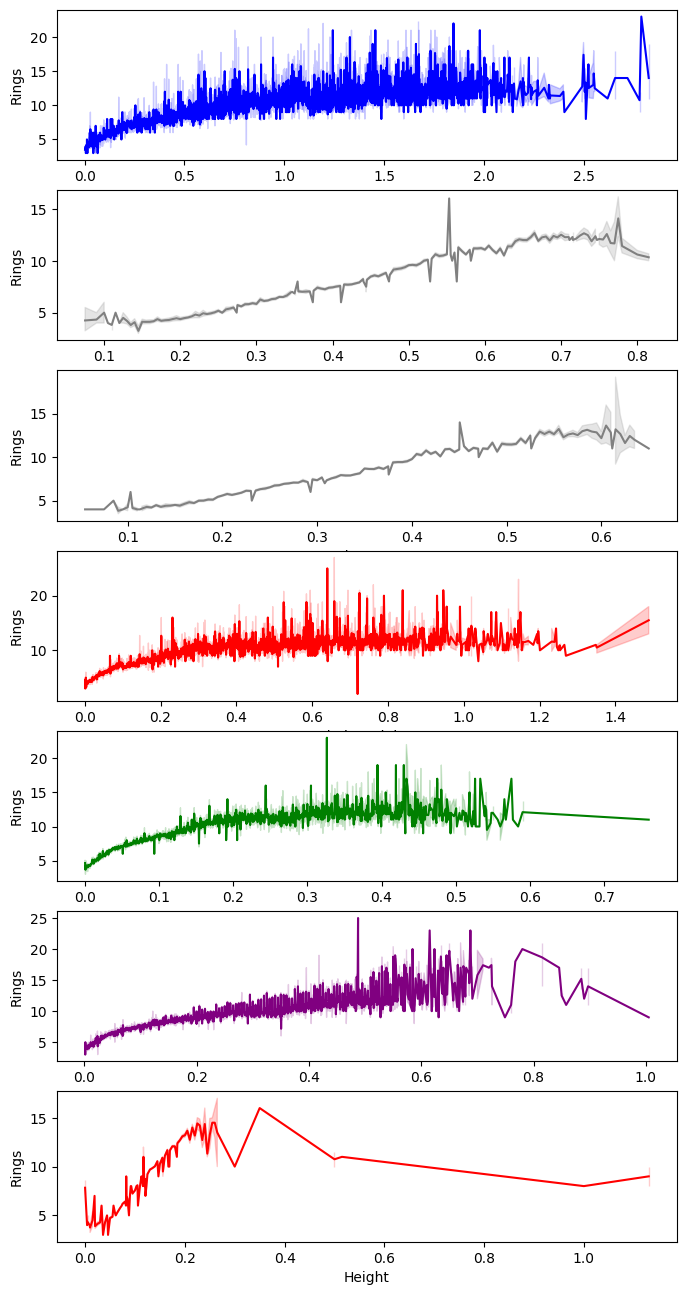

In [24]:
color=['blue','red','yellow','purple','green','gray']
fig,axes=plt.subplots(len(num_cols), 1, figsize=(8, 16))
for i,col in enumerate (num_cols):
    sns.lineplot(train,x=col,y='Rings',color=color[round(random.randint(0,5))],ax=axes[i])

Numerical columns are also strongly related with the target column

Also, Sex=Infant shows different curves completely when compared to the other two which are quite similar

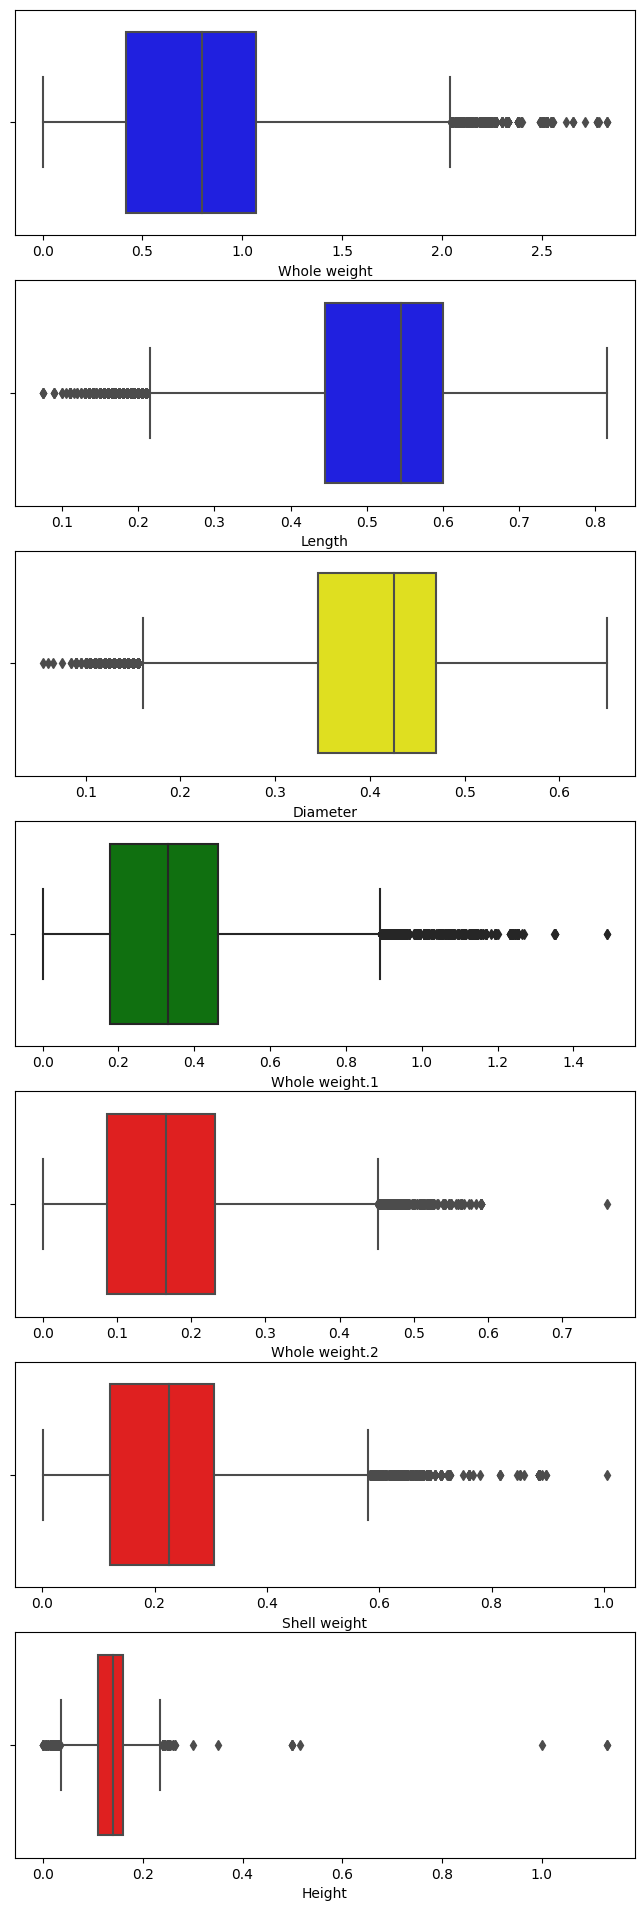

In [25]:
color=['blue','red','yellow','purple','green','gray']
fig,axes=plt.subplots(len(num_cols), 1, figsize=(8, 24))
for i,col in enumerate (num_cols):
    sns.boxplot(train,x=col,color=color[round(random.randint(0,5))],ax=axes[i])

There are a lot of outliers in the data, we will be removing them

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rings', ylabel='Count'>

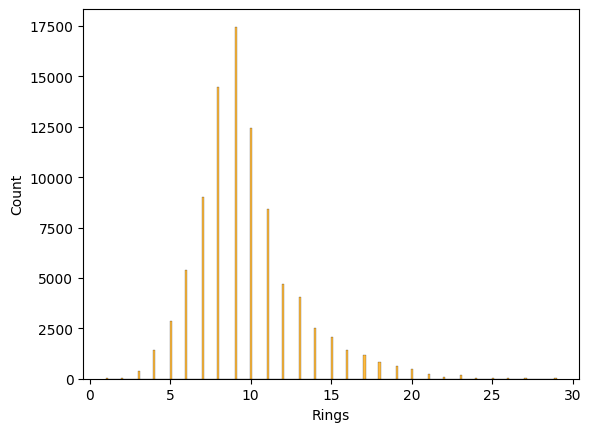

In [26]:
sns.histplot(train,x='Rings',color='orange')

In [27]:
train['Rings'].nunique()

28

Interesting thing to note is that, although it is a regression problem, we can even "try" to improve the performance by using classification as it has only 27 unqiue values and most of them lie between 5-18

<Axes: >

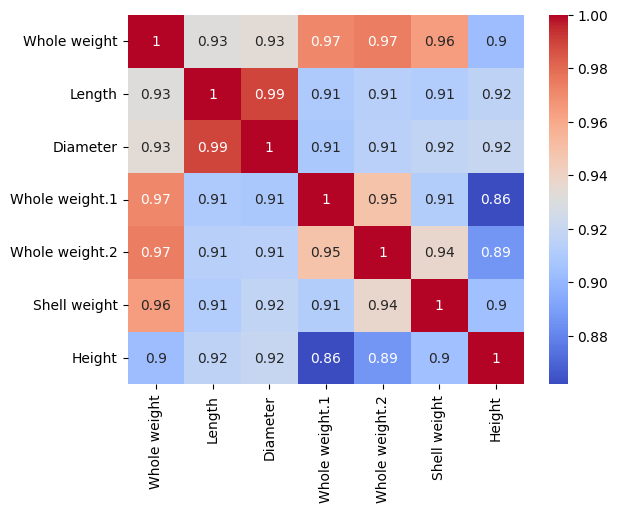

In [28]:
sns.heatmap(train[num_cols].corr(),cmap='coolwarm',annot=True)

All columns are highly correlated with each other

<Axes: xlabel='Rings', ylabel='Sex'>

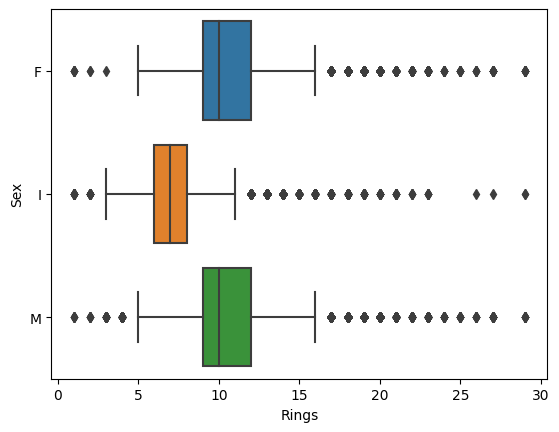

In [29]:
sns.boxplot(train,x='Rings',y='Sex')

# Feature Engineering

### Outlier Detection

In [30]:
outliers=[]
def detect(data):
    threshold=3
    data=data.astype(float)
    mean=np.mean(data)
    std=np.std(data)
    
    for i in data:
        z=(i-mean)/std
        if(np.abs(z)>threshold):
            outliers.append(i)
    return outliers

In [31]:
dia_outliers=detect(train['Diameter'])
len_outliers=detect(train['Length'])
weight_out=detect(train['Whole weight'])
weight1_out=detect(train['Whole weight.1'])
weight2_out=detect(train['Whole weight.2'])
shell_out=detect(train['Shell weight'])
height_out=detect(train['Height'])

In [32]:
outliers = height_out + dia_outliers + len_outliers + weight_out + weight1_out + weight2_out + shell_out
train = train[~train[['Height', 'Diameter', 'Length', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']].isin(outliers).any(axis=1)]

### Encoding

In [33]:
encoded_sex=pd.get_dummies(train['Sex'],drop_first=True).astype(int)
train=pd.concat([train, encoded_sex], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4699 entries, 29 to 90573
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4699 non-null   object 
 1   Length          4699 non-null   float64
 2   Diameter        4699 non-null   float64
 3   Height          4699 non-null   float64
 4   Whole weight    4699 non-null   float64
 5   Whole weight.1  4699 non-null   float64
 6   Whole weight.2  4699 non-null   float64
 7   Shell weight    4699 non-null   float64
 8   Rings           4699 non-null   int64  
 9   I               4699 non-null   int64  
 10  M               4699 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 440.5+ KB


In [34]:
train['isAdult'] = np.where((train['Sex'] == 'F') | (train['Sex'] == 'M'), 1, 0)

In [35]:
train.drop(columns=['Sex'],inplace=True)

In [36]:
test['isAdult'] = np.where((test['Sex'] == 'F') | (test['Sex'] == 'M'), 1, 0)
encoded_sex=pd.get_dummies(test['Sex'],drop_first=True).astype(int)
test=pd.concat([test, encoded_sex], axis=1)
test.drop(columns=['Sex'],inplace=True)

In [37]:
train

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,I,M,isAdult
29,0.580,0.450,0.165,1.0425,0.3745,0.2075,0.4550,20,0,1,1
63,0.585,0.460,0.165,0.9705,0.4535,0.2275,0.2450,9,0,0,1
64,0.295,0.220,0.080,0.1210,0.0505,0.0290,0.0270,5,1,0,0
69,0.695,0.565,0.235,1.8985,0.7970,0.3835,0.4385,10,0,1,1
88,0.275,0.220,0.070,0.1385,0.0560,0.0285,0.0265,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
90490,0.605,0.485,0.190,1.1290,0.4335,0.2560,0.3900,13,0,0,1
90491,0.310,0.220,0.080,0.1680,0.0740,0.0510,0.0400,8,1,0,0
90524,0.555,0.450,0.175,0.7380,0.3040,0.1755,0.2200,10,1,0,0
90567,0.330,0.240,0.080,0.1700,0.0655,0.0450,0.0490,6,1,0,0


In [38]:
test

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,isAdult,I,M
0,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1,0,1
1,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1,0,1
2,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1,0,1
3,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1,0,1
4,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0,1,0
...,...,...,...,...,...,...,...,...,...,...
60406,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,0,1,0
60407,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1,0,0
60408,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,0,1,0
60409,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1,0,0


### Creating Features

Inspirations taken from the notebook : https://www.kaggle.com/code/drewmatsumoto/ps4e4-catboost-feature-engineering

In [39]:
train['Shell ratio']=train['Shell weight']/train['Whole weight']
train['Length_to_Dia_Ratio']=train['Length']/train['Diameter']
train['Viscera Ratio']=train['Whole weight.1']/train['Whole weight']
train['Meat Yield']=train['Whole weight.2']/(train['Whole weight']+train['Shell weight'])
train['Whole_to_Viscera']=train['Whole weight']/train['Whole weight.2']
train['Whole_to_Shucked']=train['Whole weight']/train['Whole weight.1']
train['Surface Area']=2*(train['Length']*train['Diameter']+train['Length']*train['Height']+train['Diameter']*train['Height'])

In [40]:
test['Shell ratio']=test['Shell weight']/test['Whole weight'] 
test['Length_to_Dia_Ratio']=test['Length']/test['Diameter'] 
test['Viscera Ratio']=test['Whole weight.1']/test['Whole weight'] 
test['Meat Yield']=test['Whole weight.2']/(test['Whole weight']+test['Shell weight']) 
test['Whole_to_Viscera']=test['Whole weight']/test['Whole weight.2'] 
test['Whole_to_Shucked']=test['Whole weight']/test['Whole weight.1'] 
test['Surface Area']=2*(test['Length']*test['Diameter']+test['Length']*test['Height']+test['Diameter']*test['Height'])

### Scaling

In [41]:
train.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'I', 'M', 'isAdult',
       'Shell ratio', 'Length_to_Dia_Ratio', 'Viscera Ratio', 'Meat Yield',
       'Whole_to_Viscera', 'Whole_to_Shucked', 'Surface Area'],
      dtype='object')

In [42]:
cols=train.columns
input_cols=[]
for c in cols:
    if c!='Rings':
        input_cols.append(c)
target=train['Rings']

In [43]:
num_cols=[]
for cols in input_cols:
    if(cols!='I' and cols!='M' and cols!='isAdult'):
        num_cols.append(cols)
num_cols

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Shell ratio',
 'Length_to_Dia_Ratio',
 'Viscera Ratio',
 'Meat Yield',
 'Whole_to_Viscera',
 'Whole_to_Shucked',
 'Surface Area']

In [44]:
scaler=StandardScaler()
train[num_cols]=scaler.fit_transform(train[num_cols])
test[num_cols]=scaler.transform(test[num_cols])

### Transformation--
From the kdeplot, we saw that the data is skewed either to the left or right, so we will be applying transoformations to make it normally distributed

In [45]:
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
train[num_cols] = yeo_johnson_transformer.fit_transform(train[num_cols])
test[num_cols]=yeo_johnson_transformer.transform(test[num_cols])

### Feature Selection

We check if we have some columns with very low variance and we will remove them since almost const data in columns will not help the model to learn anything better

In [46]:
vt=VarianceThreshold(threshold=0.05)
vt.fit_transform(train)

array([[ 0.42193287,  0.37913857,  0.26957346, ...,  0.51347963,
         0.82237537,  0.33053579],
       [ 0.4639062 ,  0.48445336,  0.26957346, ..., -0.51508863,
        -0.95588006,  0.39378592],
       [-1.27791666, -1.2654494 , -1.20040325, ..., -0.67064806,
        -0.15804368, -1.24141723],
       ...,
       [ 0.21892544,  0.37913857,  0.5595985 , ..., -0.61556394,
        -0.06764256,  0.29898513],
       [-1.11972497, -1.16147056, -1.20040325, ..., -1.38935613,
         0.37781118, -1.16477059],
       [-1.27791666, -1.2654494 , -1.30741292, ...,  0.31301407,
         0.91239681, -1.26233876]])

In [47]:
train.columns[vt.get_support()]

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'I', 'M', 'isAdult',
       'Shell ratio', 'Length_to_Dia_Ratio', 'Viscera Ratio', 'Meat Yield',
       'Whole_to_Viscera', 'Whole_to_Shucked', 'Surface Area'],
      dtype='object')

All columns have variance >0.05, no need to remove any column uptill here

The below code is used to perform ANOVA statiscal test between each input col and target and check its importance based on its f-statistic values

In [48]:
top=SelectKBest(score_func=f_classif,k='all')
top.fit_transform(train[input_cols],target)
train[input_cols].columns[top.get_support()]

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'I', 'M', 'isAdult', 'Shell ratio',
       'Length_to_Dia_Ratio', 'Viscera Ratio', 'Meat Yield',
       'Whole_to_Viscera', 'Whole_to_Shucked', 'Surface Area'],
      dtype='object')

In [49]:
vif_data = train[input_cols]

In [50]:
for i in range(vif_data.shape[1]):
    print(vif_data.columns[i],variance_inflation_factor(vif_data.values,i))

Length 179.155708594754
Diameter 278.27355980976165
Height 18.88191009824401
Whole weight 154.76218513542753
Whole weight.1 86.95969291032941
Whole weight.2 53.28417210192003
Shell weight 39.90281247411714
I 3.008448989684739
M 1.3615338178917527
isAdult 3.271498401871302
Shell ratio 7.350848575284405
Length_to_Dia_Ratio 4.995354999769016
Viscera Ratio 60.413028560570524
Meat Yield 107.42584539765345
Whole_to_Viscera 107.8499784775259
Whole_to_Shucked 64.04001999382669
Surface Area 421.22400100798524


 VIF quantifies the severity of multicollinearity in a set of variables. Multicollinearity occurs when independent variables in a regression model are highly correlated with each other.

VIF value above 5-7 generally indicates multicollinearity. Here, since we have a very few columns and most of them have high correlation, we cant remove them. Linear Regression might not perform better, however other Ensemble methods which do not bother about multicollinearity much can be considered as a better option

Whatever techniques we used till now were filter methods.
We can also try a wrapper method like Recursive Feature Elimination here. Later after model training, we will check the feature importances and then go ahead for retraining the model using embedded methods

In [51]:
model=Ridge()
rfe=RFE(model,n_features_to_select=15)
rfe.fit(train[input_cols],target)

RFE(estimator=Ridge(), n_features_to_select=15)

In [52]:
best_features = train[input_cols].columns[rfe.support_].tolist()

In [53]:
best_features

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'I',
 'isAdult',
 'Shell ratio',
 'Viscera Ratio',
 'Meat Yield',
 'Whole_to_Viscera',
 'Whole_to_Shucked',
 'Surface Area']

Length to Diameter Ratio and M were removed during feature selection

In [54]:
X=train[best_features]
y=train['Rings']

# Model Building

We are perfroming splitting now as there was no step prior this which could lead to data leakage.

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=29)

### Linear Regression

In [56]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [57]:
lr_pred=lr.predict(X_test)
r2_score(lr_pred,y_test)

0.5570990992011853

In [58]:
sgd=SGDRegressor(loss='squared_error',penalty='l2',random_state=True)
sgd.fit(X_train,y_train)
sgd_pred=sgd.predict(X_test)
r2_score(sgd_pred,y_test)

0.5110540697301178

### SVM

In [59]:
params={
    'C': [1,5,10],
    'degree': [2,3],
    'kernel':['rbf','poly','linear'],
}

In [60]:
# svm=SVR()
# cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# grid_search=GridSearchCV(estimator=svm,param_grid=params,cv=cv,scoring='r2')
# grid_search.fit(X_train, y_train)

In [61]:
# grid_search.best_params_

In [62]:
# grid_search.best_score_

In [63]:
svm=SVR(C=5,kernel='rbf',degree=2)
svm.fit(X_train,y_train)
svm_pred=svm.predict(X_test)
r2_score(svm_pred,y_test)

0.5592575692287363

### Random Forest

In [64]:
params={
    'n_estimators':[50,100,200,500],
    'criterion':['squared_error','friedman_mse','poisson'],
    'max_depth':[10,20,50],
    'max_features':['sqrt','log2'],
}

In [65]:
# rf=RandomForestRegressor(random_state=42,n_jobs=-1)
# cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# grid_search=GridSearchCV(estimator=rf,param_grid=params,cv=cv,scoring='r2')
# grid_search.fit(X_train, y_train)

In [66]:
# grid_search.best_score_

In [67]:
# grid_search.best_params_

In [68]:
rf=RandomForestRegressor(criterion='poisson',max_depth=10,n_estimators=500,max_features='sqrt',random_state=42,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
rf_r2=r2_score(rf_pred,y_test)
rf_r2

0.593583384446197

### XGBoost

In [69]:
# after performing optuna--
xgb_params = {'n_estimators': 631, 
              'eta': 0.10068543574445041, 
              'max_depth': 28, 
              'gamma': 0.737439985663951, 
              'subsample': 0.9517065199210442, 
              'colsample_bytree': 0.7381718259540673, 
              'max_leaves': 23, 
              'grow_policy': 'depthwise'
             }

In [70]:
xgb=XGBRegressor(n_jobs=-1,random_state=42,**xgb_params)
xgb.fit(X_train,y_train)
xgb_pred=xgb.predict(X_test)
xgb_r2=r2_score(xgb_pred,y_test)
xgb_r2

0.6041648390591086

### LightGBM

In [71]:
#After optuna hyperparameter tuning--
lgb_params = {'learning_rate': 0.09379817857274081, 
              'num_leaves': 125, 
              'subsample': 0.8431319263894246, 
              'colsample_bytree': 0.5737935980423815, 
              'min_child_samples': 39, 
              'reg_alpha': 8.780851251850981, 
              'reg_lambda': 2.905428856663929,
              'verbose':-1
             }
from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(random_state=42,**lgb_params)
lgbm.fit(X_train,y_train)
lgbm_pred=lgbm.predict(X_test)
lgbm_r2=r2_score(lgbm_pred,y_test)
lgbm_r2

0.5898476932358199

### CatBoost

In [72]:
cat=CatBoostRegressor(verbose=False)
cat.fit(X_train,y_train)
cat_pred=cat.predict(X_test)
cat_r2=r2_score(cat_pred,y_test)
cat_r2

0.6159384679937557

In [73]:
n=X_train.shape[0]
k=X_train.shape[1]
def adjusted_r2(r2):
    return 1-(((1-r2)*(n-1))/(n-k-1))

In [74]:
print('Adjusted R2 for Random Forest:',adjusted_r2(rf_r2))
print('Adjusted R2 for XGBoost:',adjusted_r2(xgb_r2))
print('Adjusted R2 for CatBoost:',adjusted_r2(cat_r2))
print('Adjusted R2 for LightGBM:',adjusted_r2(lgbm_r2))

Adjusted R2 for Random Forest: 0.5919546777314475
Adjusted R2 for XGBoost: 0.6025785373187631
Adjusted R2 for CatBoost: 0.6143993488433166
Adjusted R2 for LightGBM: 0.5882040158109032


In [75]:
def rmsle(y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))

In [76]:
print('RMSLE for Random Forest:',rmsle(rf_pred))
print('RMSLE for XGBoost:',rmsle(xgb_pred))
print('RMSLE for CatBoost:',rmsle(cat_pred))
print('RMSLE for LightGBM:',rmsle(lgbm_pred))

RMSLE for Random Forest: 0.18737979941947616
RMSLE for XGBoost: 0.19136896035433898
RMSLE for CatBoost: 0.1869759679009158
RMSLE for LightGBM: 0.19002184377596032


### Voting Regressor

In [77]:
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('cat', cat)
])
vr.fit(X_train,y_train)
vr_pred=vr.predict(X_test)
vr_r2=r2_score(vr_pred,y_test)
vr_r2

0.6070006487328521

In [78]:
print(adjusted_r2(vr_r2))
print(rmsle(vr_pred))

0.6054257114448459
0.1868840737594137


RMLSE of Voting Regressor is the best

# Neural Networks

In [79]:
model=Sequential()
model.add(Dense(64,activation='relu',input_dim=15))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,153 (238.88 KB)

 Trainable params: 60,513 (236.38 KB)

 Non-trainable params: 640 (2.50 KB)

In [81]:
model.compile(loss="mean_squared_error",optimizer = "Adam",metrics=['mse'])

In [82]:
model.fit(X_train,y_train,epochs=100)

Epoch 1/100
 82/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.8641 - mse: 31.8641

I0000 00:00:1714423901.488749     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 26.2829 - mse: 26.2835
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3287 - mse: 6.3289
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8870 - mse: 5.8873
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3870 - mse: 5.3873
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6013 - mse: 5.6013
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6033 - mse: 5.6034
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2839 - mse: 5.2837
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3978 - mse: 5.3970
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6241 - mse: 5.6243
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4524 - mse: 5.4525
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4374 - mse: 5.4372
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0276 - mse: 5.0278
Epoch 13/100
118/118 ━

In [83]:
model_pred=model.predict(X_test)
model_r2=r2_score(model_pred,y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [84]:
rmsle(model_pred)

0.19446967849476998

## Submission

In [85]:
sample_submission=pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
sample_submission

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10
...,...,...
60406,151021,10
60407,151022,10
60408,151023,10
60409,151024,10


In [86]:
test

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,isAdult,I,M,Shell ratio,Length_to_Dia_Ratio,Viscera Ratio,Meat Yield,Whole_to_Viscera,Whole_to_Shucked,Surface Area
0,1.001119,0.648129,0.008494,0.785648,1.165073,1.140939,0.346331,1,0,1,-1.375945,0.853094,1.250510,1.286496,-1.042376,-1.428685,0.630128
1,0.421933,0.484453,0.135362,0.327261,0.662487,0.399914,0.177974,1,0,1,-0.310767,-0.651184,1.118540,0.313567,-0.184168,-1.245514,0.343928
2,0.258595,0.082234,-0.326808,0.067962,0.169510,0.113858,-0.044226,1,0,1,-0.144864,0.526928,0.288111,0.183254,-0.079681,-0.200129,-0.004678
3,0.339343,0.818461,-0.222725,0.130407,0.169510,0.130340,-0.078995,1,0,1,-0.597478,-2.715086,0.030311,0.086904,0.107885,0.076150,0.342736
4,-0.695185,-0.662445,-0.827114,-0.810280,-0.705777,-0.883485,-0.857931,0,1,0,0.014239,-0.358857,0.567537,-0.806798,0.839040,-0.527819,-0.772373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,-1.049302,-1.053068,-1.144086,-1.141972,-1.119327,-1.237382,-1.169389,0,1,0,-0.262144,0.437110,0.200792,-1.958147,1.897067,-0.103647,-1.096951
60407,-0.008861,-0.010117,-0.222725,0.077017,0.315426,-0.031170,-0.265533,1,0,0,-1.375400,-0.296153,0.818933,-0.248871,0.549093,-0.844770,-0.121218
60408,0.506325,0.276946,0.008494,0.577461,0.333348,0.241144,0.112873,0,1,0,-1.589832,0.630383,-0.972616,-0.827060,1.081520,0.979795,0.261481
60409,1.144625,1.240728,1.047240,1.242560,1.060491,1.492105,1.280189,1,0,0,-0.032271,-0.721261,-0.125633,0.692738,-0.661830,0.231247,1.230129


In [87]:
test.drop(columns=['M','Length_to_Dia_Ratio'],inplace=True)

In [88]:
X_train.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'I', 'isAdult', 'Shell ratio',
       'Viscera Ratio', 'Meat Yield', 'Whole_to_Viscera', 'Whole_to_Shucked',
       'Surface Area'],
      dtype='object')

In [89]:
test2=test[best_features]

In [90]:
test_pred=vr.predict(test2)
test_pred=np.round(test_pred).astype('int')
test_pred

array([10,  9, 12, ..., 12, 14,  8])

In [91]:
sample_submission['Rings']=test_pred
sample_submission

,id,Rings
0,90615,10
1,90616,9
2,90617,12
3,90618,11
4,90619,7
...,...,...
60406,151021,6
60407,151022,10
60408,151023,12
60409,151024,14


In [92]:
sample_submission.to_csv('abalone.csv',index=False)